In [1]:
from api import inoreader_api, inoreader_scraping
import json
import pandas as pd
import re
import random
import pickle
import numpy as np

percentile = 33.3
workers_split = 0.8
manager_split = 0.8


def rewrite(x):
    return x

# Scrape feeds starting from a concrete moment and store them in a file.

In [2]:
start_time = 1517463300 #1508112001
feed = 'user/-/label/arXiv'
file_name = 'articles_raw.json'

number_scraped = inoreader_scraping.scrape(feed, start_time, file_name)
print(number_scraped)


Requesting: stream/contents/user/-/label/arXiv
200 OK
20


# Load the feeds from disk.

In [3]:
f = open(file_name, 'r')
json_string = f.read()
f.close

json_object = json.loads(json_string)
all_articles = json_object['all_articles']

In [4]:
def get_abstract_string(abs_dict):
    abs_string = abs_dict['content']
    abs_string = re.search('<p>(.*)</p>', abs_string, flags=re.DOTALL)
    return abs_string.group(1)

In [5]:
def get_canonical_string(canonical_list):
    url_dict = canonical_list[0]
    url = url_dict['href']
    return url

# Create preprocessed and cleaned DataFrame.

In [6]:
all_articles_pd = pd.DataFrame(all_articles)
all_articles_pd = all_articles_pd[['canonical', 'author', 'categories', 'published', 'title', 'summary']]

for i in range(len(all_articles_pd)):
    all_articles_pd['summary'][i] = get_abstract_string(all_articles_pd['summary'][i])
    all_articles_pd['canonical'][i] = get_canonical_string(all_articles_pd['canonical'][i])
    
all_articles_pd['read'] = False
all_articles_pd['liked'] = False

for i in range(len(all_articles_pd)):
    if 'user/1005689817/state/com.google/read' in all_articles_pd['categories'][i]:
        all_articles_pd['read'][i] = True
    if 'user/1005689817/state/com.google/like' in all_articles_pd['categories'][i]:
        all_articles_pd['liked'][i] = True

del all_articles_pd['categories']

/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyW

In [7]:
#all_articles_pd

In [8]:
tagged_articles_pd = all_articles_pd[all_articles_pd['read'] == True]

with open('old_articles_good_and_bad.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    old_tagged_articles_pd = pickle.load(f)
    
print(len(tagged_articles_pd))
print(len(old_tagged_articles_pd))
    
tagged_articles_pd = pd.concat([tagged_articles_pd, old_tagged_articles_pd])

20
2826


In [9]:
tagged_articles_unique_pd = tagged_articles_pd.sort_values(by=['canonical', 'liked'], ascending=False).reset_index(drop=True)
to_drop = tagged_articles_unique_pd.duplicated(subset = ['canonical'], keep='first')
to_drop = list(to_drop[to_drop == False].index.values)

tagged_articles_unique_pd = tagged_articles_unique_pd[tagged_articles_unique_pd.index.isin(to_drop)]

In [10]:
print(len(tagged_articles_pd))
print(len(tagged_articles_unique_pd))

2846
2826


In [11]:
# Do you want to save new dataset?
if True:
    with open('old_articles_good_and_bad.pickle', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(tagged_articles_unique_pd, f, pickle.HIGHEST_PROTOCOL)

    del tagged_articles_unique_pd

    with open('old_articles_good_and_bad.pickle', 'rb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        tagged_articles_unique_pd = pickle.load(f)

In [12]:
X_ = list(tagged_articles_unique_pd['author']+' '+tagged_articles_unique_pd['title']+' '+tagged_articles_unique_pd['summary'])
y_ = list(tagged_articles_unique_pd['liked'])

In [13]:
index_shuffled = [i for i in range(len(X_))]
random.shuffle(index_shuffled)
X = []
y = []
for i in index_shuffled:
    X.append(X_[i])
    y.append(y_[i])

In [14]:
with open('stopwords/english') as f:
    stopwords = [line.strip() for line in f]

In [15]:


def text_to_word_sequence(text,
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                          lower=True, split=" "):
    if lower: text = text.lower()
    if type(text) == str:
        translate_table = {ord(c): ord(t) for c,t in zip(filters, split*len(filters)) }
    else:
        translate_table = maketrans(filters, split * len(filters))
    text = text.translate(translate_table)
    seq = text.split(split)
    return [i for i in seq if i]

print(len(X[4]))

for i in range(len(X)):
    seq = text_to_word_sequence(X[i])
    clean_seq = [word for word in seq if word not in stopwords]
    X[i] = ' '.join(clean_seq)
    
print(len(X[4]))

883
717


# Saving or loading the data and LE and tokenizer

In [16]:
import pickle

data_dict = {
    'X' : X,
    'y' : y
}
pickle.dump(data_dict,open("data.pickle", "wb" ) )


limit = int(0.8*len(X))
print(limit)

2260


In [17]:
import pickle
data_dict = pickle.load(open( "data.pickle", "rb" ) )
X = data_dict['X']
y = data_dict['y']
limit = int(workers_split*len(X))
print(limit)

2260


In [18]:
X_ = X
y_ = y
index_shuffled = [i for i in range(len(X_))]
random.shuffle(index_shuffled)
X = []
y = []
for i in index_shuffled:
    X.append(X_[i])
    y.append(y_[i])

# TFIDF -> NB

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit


model_nb_tfidf = Pipeline([
    ("tfidf_vectorizer", TfidfVectorizer()),\
    ("nb", BernoulliNB())
])


X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

model_nb_tfidf.fit(X_train, y_train)

y_predicted = model_nb_tfidf.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
acc, f1

/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(0.8568904593639576, 0.9211958168277945)

In [20]:
y_predicted_proba = model_nb_tfidf.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.15)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)/len(y_predicted)*100.0,"% - ", int(sum(y_predicted)/len(y_predicted)*50.0))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

0.6696113074204947 0.6249163501226127 189 566
33.39222614840989 % -  16


Rejected 69.63% of wrong ones
Accepted 51.22% of good ones


/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


array([[1.00000000e+00, 1.20365054e-11],
       [1.00000000e+00, 1.09298861e-25],
       [1.00000000e+00, 1.83262803e-16],
       [1.00000000e+00, 1.68716184e-25],
       [1.00000000e+00, 8.51393034e-24]])

# CountVect -> NB

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit


model_nb = Pipeline([
    #('vect', CountVectorizer(ngram_range=(1,3),stop_words='english')),\
    ("count_vectorizer", CountVectorizer(analyzer=rewrite)),\
    ("nb", BernoulliNB())
])

X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

model_nb.fit(X_train, y_train)

y_predicted = model_nb.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
acc, f1

/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.8551236749116607, 0.9219047619047619)

In [22]:
y_predicted_proba = model_nb.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.1296)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

0.6342756183745583 0.5848004517400045 189 566
33.3922261484099 % -  16


Rejected 67.56% of wrong ones
Accepted 39.02% of good ones


array([[0.8651149 , 0.1348851 ],
       [0.8580219 , 0.1419781 ],
       [0.87645224, 0.12354776],
       [0.88077268, 0.11922732],
       [0.89556866, 0.10443134]])

# TFIDF -> SVC

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

model_svc_tfidf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,3), min_df=1, max_df=1.0,stop_words='english')),
    #('vect', CountVectorizer(ngram_range=(3,6),analyzer='char_wb', min_df=10, max_df=0.95,stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ("svc", SVC(kernel='linear', probability=True, class_weight = 'balanced'))
    #("svc", SVC(kernel='linear', probability=True))
])

X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

model_svc_tfidf.fit(X_train, y_train)

y_predicted = model_svc_tfidf.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
acc, f1

/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(0.8551236749116607, 0.8947943594742093)

In [24]:
y_predicted_proba = model_svc_tfidf.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

#(0.62077922077922076, 0.55417162908266104, 162, 385)
#(42.077922077922075, '% - ', 21)
#('Rejected good ones: ', 15, '/', 46)
#('Accepted wrong ones:', 131, '/', 339)
#('Rejected wrong ones: ', 208, '/', 339)
#('Accepted good ones:', 31, '/', 46)

/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


0.6837455830388692 0.6409627094756561 189 566
33.3922261484099 % -  16


Rejected 70.45% of wrong ones
Accepted 56.10% of good ones


array([[0.30401739, 0.69598261],
       [0.93064309, 0.06935691],
       [0.26261182, 0.73738818],
       [0.94961737, 0.05038263],
       [0.64480508, 0.35519492]])

In [25]:
(len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/len(y_test)-sum(y_test))


-21.752650176678443

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

model_svc_tfidf = Pipeline([
    #('vect', CountVectorizer(ngram_range=(1,3), min_df=1, max_df=1.0,stop_words='english')),
    ('vect', CountVectorizer(ngram_range=(3,6),analyzer='char_wb', min_df=10, max_df=0.95,stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ("svc", SVC(kernel='linear', probability=True, class_weight = 'balanced'))
    #("svc", SVC(kernel='linear', probability=True))
])

X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

model_svc_tfidf.fit(X_train, y_train)

y_predicted = model_svc_tfidf.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
acc, f1

/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(0.7685512367491166, 0.7511766555672601)

In [27]:
y_predicted_proba = model_svc_tfidf.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

#(0.62077922077922076, 0.55417162908266104, 162, 385)
#(42.077922077922075, '% - ', 21)
#('Rejected good ones: ', 15, '/', 46)
#('Accepted wrong ones:', 131, '/', 339)
#('Rejected wrong ones: ', 208, '/', 339)
#('Accepted good ones:', 31, '/', 46)

/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


0.6731448763250883 0.6289279399608737 189 566
33.3922261484099 % -  16


Rejected 69.83% of wrong ones
Accepted 52.44% of good ones


array([[0.61847531, 0.38152469],
       [0.9401417 , 0.0598583 ],
       [0.62974138, 0.37025862],
       [0.94740495, 0.05259505],
       [0.85043041, 0.14956959]])

# Count -> SVC

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

model_svc = Pipeline([
    #('vect', CountVectorizer()),
    ('vect', CountVectorizer(ngram_range=(1,3), min_df=1, max_df=1.0,stop_words='english')),
    #('vect', CountVectorizer(ngram_range=(3,6),analyzer='char_wb', min_df=10, max_df=0.95,stop_words='english')),
    #('tfidf', TfidfTransformer()),
    ("svc", SVC(kernel='linear', probability=True, class_weight = 'balanced'))
    #("svc", SVC(kernel='linear', probability=True))
])

X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

model_svc.fit(X_train, y_train)

y_predicted = model_svc.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
acc, f1

(0.8462897526501767, 0.8997122043122288)

In [29]:
y_predicted_proba = model_svc.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

#(0.62077922077922076, 0.55417162908266104, 162, 385)
#(42.077922077922075, '% - ', 21)
#('Rejected good ones: ', 15, '/', 46)
#('Accepted wrong ones:', 131, '/', 339)
#('Rejected wrong ones: ', 208, '/', 339)
#('Accepted good ones:', 31, '/', 46)

0.6731448763250883 0.6289279399608737 189 566
33.3922261484099 % -  16


Rejected 69.83% of wrong ones
Accepted 52.44% of good ones


array([[0.66019501, 0.33980499],
       [0.87670942, 0.12329058],
       [0.70794005, 0.29205995],
       [0.91087068, 0.08912932],
       [0.82596868, 0.17403132]])

# Extree - pretrained

In [30]:
test = ['raz']
'_'.join(test)

'raz'

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from gensim.models.word2vec import Word2Vec

import numpy as np

import models.embedding_matrix as embedding
#reload(embedding)

DATASETS_DIR = '../ml-research/datasets/'
WIKI_DIR = DATASETS_DIR+'wiki.pl/'
embeddings_file = WIKI_DIR+'wiki.pl.vec'

print('Indexing word vectors.')

word2vec_pretrained = {}
f = open(embeddings_file, encoding='utf-8')

for line in f:
    values = line.split()
    word = '_'.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    word2vec_pretrained[word] = coefs
f.close()

# train word2vec on all the texts - both training and test set
# we're not using test labels, just texts so this is fine
model = Word2Vec(X, size=100, window=5, min_count=5, workers=2)
w2v_custom = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

Indexing word vectors.


In [32]:
from collections import defaultdict


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.items())))
        
    
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
# and a tf-idf version of the same

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(word2vec.items())))
        
    def max_idf_func():
        return self.max_idf
        
    def fit(self, X, y):
        #tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf = TfidfVectorizer(analyzer=rewrite)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        self.max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            #lambda: max_idf, 
            self.max_idf_func, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [33]:
# Extra Trees classifier is almost universally great, let's stack it with our embeddings

etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(word2vec_pretrained)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=50))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(word2vec_pretrained)), 
                        ("svc", ExtraTreesClassifier(n_estimators=50))])
svc_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(word2vec_pretrained)), 
                        ("extra trees", SVC(kernel="linear", probability=True))])
svc_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(word2vec_pretrained)), 
                        ("svc", SVC(kernel="linear", probability=True))])

In [34]:
import numpy as np
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

etree_w2v.fit(X_train, y_train)

y_predicted = etree_w2v.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = etree_w2v.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

0.6607773851590106 0.62044741839679 162 566
28.62190812720848 % -  14


Rejected 71.90% of wrong ones
Accepted 31.71% of good ones


array([[0.88, 0.12],
       [0.72, 0.28],
       [0.6 , 0.4 ],
       [0.98, 0.02],
       [0.92, 0.08]])

In [35]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

etree_w2v_tfidf.fit(X_train, y_train)

y_predicted = etree_w2v_tfidf.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = etree_w2v_tfidf.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

0.6378091872791519 0.590673446028085 179 566
31.625441696113075 % -  15


Rejected 68.80% of wrong ones
Accepted 34.15% of good ones


array([[0.84, 0.16],
       [0.74, 0.26],
       [0.72, 0.28],
       [0.92, 0.08],
       [0.8 , 0.2 ]])

In [36]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

svc_w2v.fit(X_train, y_train)

y_predicted = svc_w2v.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = svc_w2v.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.6130742049469965 0.5607309127104396 189 566
33.3922261484099 % -  16


Rejected 66.32% of wrong ones
Accepted 31.71% of good ones


array([[0.86076473, 0.13923527],
       [0.8489032 , 0.1510968 ],
       [0.84389459, 0.15610541],
       [0.87988403, 0.12011597],
       [0.8377424 , 0.1622576 ]])

In [37]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

svc_w2v_tfidf.fit(X_train, y_train)

y_predicted = svc_w2v_tfidf.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = svc_w2v_tfidf.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.6307420494699647 0.5807888619017436 189 566
33.3922261484099 % -  16


Rejected 67.36% of wrong ones
Accepted 37.80% of good ones


array([[0.85473874, 0.14526126],
       [0.87237684, 0.12762316],
       [0.85107407, 0.14892593],
       [0.87847818, 0.12152182],
       [0.82977453, 0.17022547]])

# Extree - Custom embeddings

In [38]:
# Extra Trees classifier is almost universally great, let's stack it with our embeddings

etree_w2v_custom = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v_custom)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=50))])
etree_w2v_tfidf_custom = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v_custom)), 
                        ("svc", ExtraTreesClassifier(n_estimators=50))])
svc_w2v_custom = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v_custom)), 
                        ("extra trees", SVC(kernel="linear", probability=True))])
svc_w2v_tfidf_custom = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v_custom)), 
                        ("svc", SVC(kernel="linear", probability=True))])

In [39]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

etree_w2v_custom.fit(X_train, y_train)

y_predicted = etree_w2v_custom.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = etree_w2v_custom.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

0.6678445229681979 0.625197487281678 176 566
31.09540636042403 % -  15


Rejected 70.87% of wrong ones
Accepted 42.68% of good ones


array([[0.94, 0.06],
       [0.74, 0.26],
       [0.84, 0.16],
       [0.98, 0.02],
       [0.94, 0.06]])

In [40]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

etree_w2v_tfidf_custom.fit(X_train, y_train)

y_predicted = etree_w2v_tfidf_custom.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = etree_w2v_tfidf_custom.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

0.676678445229682 0.6384878666766575 161 566
28.445229681978798 % -  14


Rejected 72.93% of wrong ones
Accepted 36.59% of good ones


array([[0.94, 0.06],
       [0.76, 0.24],
       [0.86, 0.14],
       [0.94, 0.06],
       [0.96, 0.04]])

In [41]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

svc_w2v_custom.fit(X_train, y_train)

y_predicted = svc_w2v_custom.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = svc_w2v_custom.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.6060070671378092 0.552707733033918 189 566
33.3922261484099 % -  16


Rejected 65.91% of wrong ones
Accepted 29.27% of good ones


array([[0.85987574, 0.14012426],
       [0.85734273, 0.14265727],
       [0.86075493, 0.13924507],
       [0.86187167, 0.13812833],
       [0.85373754, 0.14626246]])

In [42]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

svc_w2v_tfidf_custom.fit(X_train, y_train)

y_predicted = svc_w2v_tfidf_custom.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = svc_w2v_tfidf_custom.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.6378091872791519 0.5888120415782652 189 566
33.3922261484099 % -  16


Rejected 67.77% of wrong ones
Accepted 40.24% of good ones


array([[0.85129995, 0.14870005],
       [0.85682874, 0.14317126],
       [0.85241667, 0.14758333],
       [0.86856864, 0.13143136],
       [0.86313104, 0.13686896]])

# Logistic regression and SGD - both on embeddings

In [43]:
from sklearn.linear_model import SGDClassifier, LogisticRegression

logistic_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(word2vec_pretrained)), 
                        ("logistic", LogisticRegression())])
logistic_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(word2vec_pretrained)), 
                        ("logistic", LogisticRegression())])

In [44]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

logistic_w2v.fit(X_train, y_train)

y_predicted = logistic_w2v.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = logistic_w2v.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.6554770318021201 0.6088699907695696 189 566
33.3922261484099 % -  16


Rejected 68.80% of wrong ones
Accepted 46.34% of good ones


array([[0.84211101, 0.15788899],
       [0.84991373, 0.15008627],
       [0.76536361, 0.23463639],
       [0.8894035 , 0.1105965 ],
       [0.85846224, 0.14153776]])

In [45]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

logistic_w2v_tfidf.fit(X_train, y_train)

y_predicted = logistic_w2v_tfidf.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = logistic_w2v_tfidf.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.6554770318021201 0.6088699907695696 189 566
33.3922261484099 % -  16


Rejected 68.80% of wrong ones
Accepted 46.34% of good ones


array([[0.84258132, 0.15741868],
       [0.85088588, 0.14911412],
       [0.76661231, 0.23338769],
       [0.88918848, 0.11081152],
       [0.85845565, 0.14154435]])

In [46]:
from sklearn.linear_model import SGDClassifier, LogisticRegression

sgd_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(word2vec_pretrained)), 
                        ("logistic", SGDClassifier(loss = 'log'))])
sgd_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(word2vec_pretrained)), 
                        ("logistic", SGDClassifier(loss = 'log'))])

In [47]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

sgd_w2v.fit(X_train, y_train)

y_predicted = sgd_w2v.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = sgd_w2v.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.6484098939929329 0.6008468110930478 189 566
33.3922261484099 % -  16


Rejected 68.39% of wrong ones
Accepted 43.90% of good ones


array([[9.98736672e-01, 1.26332764e-03],
       [9.99171406e-01, 8.28594454e-04],
       [9.80813612e-01, 1.91863879e-02],
       [9.99875906e-01, 1.24093738e-04],
       [9.99356692e-01, 6.43307560e-04]])

In [48]:
X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

sgd_w2v_tfidf.fit(X_train, y_train)

y_predicted = sgd_w2v_tfidf.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = sgd_w2v_tfidf.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.12)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))

y_predicted_proba[0:5]

0.6448763250883393 0.5968352212547869 189 566
33.3922261484099 % -  16


Rejected 68.18% of wrong ones
Accepted 42.68% of good ones


array([[0.93485347, 0.06514653],
       [0.95274659, 0.04725341],
       [0.41316528, 0.58683472],
       [0.9887392 , 0.0112608 ],
       [0.96209921, 0.03790079]])

# Saving/loading models

In [49]:
import time
def datetime_string():
    localtime = time.localtime(time.time())
    datetime_str = str(localtime.tm_year)
    if(localtime.tm_mon < 10):
        datetime_str += '0'
    datetime_str += str(localtime.tm_mon)
    if(localtime.tm_mday < 10):
        datetime_str += '0'
    datetime_str += str(localtime.tm_mday) + '_'
    if(localtime.tm_hour < 10):
        datetime_str += '0'
    datetime_str += str(localtime.tm_hour)
    if(localtime.tm_min < 10):
        datetime_str += '0'
    datetime_str += str(localtime.tm_min) + '_'
    
    return datetime_str

In [50]:
import pickle

contents_dict = {
    'model_svc_sklearn' : model_svc,
    'model_svc_tfidf_sklearn' : model_svc_tfidf,
    
    'model_nb_sklearn' : model_nb,
    'model_nb_tfidf_sklearn' : model_nb_tfidf,
    
    'etree_w2v_sklearn' : etree_w2v,
    'etree_w2v_tfidf_sklearn' : etree_w2v_tfidf,
    
    'svc_w2v_sklearn' : svc_w2v,
    'svc_w2v_tfidf_sklearn' : svc_w2v_tfidf,
    
    'etree_w2v_custom_sklearn' : etree_w2v_custom,
    'etree_w2v_tfidf_custom_sklearn' : etree_w2v_tfidf_custom,
    
    'svc_w2v_custom_sklearn' : svc_w2v_custom,
    'svc_w2v_tfidf_custom_sklearn' : svc_w2v_tfidf_custom,
    
    'logistic_w2v_sklearn' : logistic_w2v,
    'logistic_w2v_tfidf_sklearn' : logistic_w2v_tfidf,
    
    'sgd_w2v_sklearn' : sgd_w2v,
    'sgd_w2v_tfidf_sklearn' : sgd_w2v_tfidf
}

dat_str = datetime_string()
with open("models/"+dat_str+"ensemble_models.pickle", 'wb') as f:
    pickle.dump(contents_dict, f, pickle.HIGHEST_PROTOCOL)

In [51]:
with open('models/'+dat_str+'ensemble_models.pickle', 'rb') as f:
    contents_dict = pickle.load(f)

model_svc = contents_dict['model_svc_sklearn']
model_svc_tfidf = contents_dict['model_svc_tfidf_sklearn']

model_nb = contents_dict['model_nb_sklearn']
model_nb_tfidf = contents_dict['model_nb_tfidf_sklearn']

etree_w2v = contents_dict['etree_w2v_sklearn']
etree_w2v_tfidf = contents_dict['etree_w2v_tfidf_sklearn']

svc_w2v = contents_dict['svc_w2v_sklearn']
svc_w2v_tfidf = contents_dict['svc_w2v_tfidf_sklearn']

etree_w2v_custom = contents_dict['etree_w2v_custom_sklearn']
etree_w2v_tfidf_custom = contents_dict['etree_w2v_tfidf_custom_sklearn']

svc_w2v_custom = contents_dict['svc_w2v_custom_sklearn']
svc_w2v_tfidf_custom = contents_dict['svc_w2v_tfidf_custom_sklearn']

logistic_w2v = contents_dict['logistic_w2v_sklearn']
logistic_w2v_tfidf = contents_dict['logistic_w2v_tfidf_sklearn']

sgd_w2v = contents_dict['sgd_w2v_sklearn']
sgd_w2v_tfidf = contents_dict['sgd_w2v_tfidf_sklearn']

#hyperparameters_cnn = contents_dict['hyperparameters_cnn']
#hyperparameters_lstm = contents_dict['hyperparameters_lstm']

#label_encoder = contents_dict['label_encoder']
#tokenize = contents_dict['tokenizer']

# Building an ensembler - Without data leakage

In [52]:
XE = X[limit:]
yE = y[limit:]

In [53]:
import numpy as np
XE_intermediate = np.column_stack((
        model_svc.predict_proba(XE)[:,1],
        model_svc_tfidf.predict_proba(XE)[:,1],
    
        model_nb.predict_proba(XE)[:,1],
        model_nb_tfidf.predict_proba(XE)[:,1],

        etree_w2v.predict_proba(XE)[:,1],
        etree_w2v_tfidf.predict_proba(XE)[:,1],

        svc_w2v.predict_proba(XE)[:,1],
        svc_w2v_tfidf.predict_proba(XE)[:,1],

        etree_w2v_custom.predict_proba(XE)[:,1],
        etree_w2v_tfidf_custom.predict_proba(XE)[:,1],

        svc_w2v_custom.predict_proba(XE)[:,1],
        svc_w2v_tfidf_custom.predict_proba(XE)[:,1],

        logistic_w2v.predict_proba(XE)[:,1],
        logistic_w2v_tfidf.predict_proba(XE)[:,1],

        sgd_w2v.predict_proba(XE)[:,1],
        sgd_w2v_tfidf.predict_proba(XE)[:,1]
    ))
XE_intermediate

/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


array([[3.39804988e-01, 3.81524689e-01, 1.34885101e-01, ...,
        1.57418678e-01, 1.26332764e-03, 6.51465254e-02],
       [1.23290579e-01, 5.98582988e-02, 1.41978101e-01, ...,
        1.49114125e-01, 8.28594454e-04, 4.72534144e-02],
       [2.92059950e-01, 3.70258616e-01, 1.23547755e-01, ...,
        2.33387687e-01, 1.91863879e-02, 5.86834719e-01],
       ...,
       [8.47294064e-02, 6.25996674e-02, 1.41224648e-01, ...,
        8.57452225e-02, 1.57450276e-05, 3.47356746e-03],
       [8.68772941e-02, 5.14922112e-02, 2.05290429e-01, ...,
        1.76177557e-01, 2.21993740e-03, 1.13807602e-01],
       [5.77106553e-02, 4.75357888e-02, 8.37646632e-02, ...,
        8.45256167e-02, 3.40050064e-05, 1.60447352e-03]])

In [54]:
limitE = int(manager_split*len(XE_intermediate))
print(limitE)

X_train = XE_intermediate[:limitE]
X_test = XE_intermediate[limitE:]

y_train = yE[:limitE]
y_test = yE[limitE:]

452


In [55]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

logi = LogisticRegression()
logi.fit(X_train, y_train)

y_predicted = logi.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = logi.predict_proba(X_test)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))
print("Median: %.3f" % np.median(y_predicted_proba[:,1]))

y_predicted_proba[0:5]

0.6666666666666666 0.6124708624708625 38 114
33.333333333333336 % -  16


Rejected 69.00% of wrong ones
Accepted 50.00% of good ones
Median: 0.139


/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


array([[0.88491249, 0.11508751],
       [0.85235219, 0.14764781],
       [0.80749649, 0.19250351],
       [0.85671897, 0.14328103],
       [0.84576315, 0.15423685]])

# Best ratings:
Rejected 53.94% of wrong ones

Accepted 77.05% of good ones

Median: 0.043

In [56]:
import numpy as np
max_rej = 20.0
max_acc = 20.0

XE_intermediate_full = np.column_stack((
        model_svc.predict_proba(XE)[:,1],
        model_svc_tfidf.predict_proba(XE)[:,1],

        model_nb.predict_proba(XE)[:,1],
        model_nb_tfidf.predict_proba(XE)[:,1], #----------

        etree_w2v.predict_proba(XE)[:,1],
        etree_w2v_tfidf.predict_proba(XE)[:,1],

        svc_w2v.predict_proba(XE)[:,1],
        svc_w2v_tfidf.predict_proba(XE)[:,1], #----------

        etree_w2v_custom.predict_proba(XE)[:,1],
        etree_w2v_tfidf_custom.predict_proba(XE)[:,1],

        svc_w2v_custom.predict_proba(XE)[:,1],
        svc_w2v_tfidf_custom.predict_proba(XE)[:,1], #----------

        logistic_w2v.predict_proba(XE)[:,1],
        logistic_w2v_tfidf.predict_proba(XE)[:,1],

        sgd_w2v.predict_proba(XE)[:,1],
        sgd_w2v_tfidf.predict_proba(XE)[:,1]
    ))
print("Done!")

/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Done!


In [57]:
threshold = 0.0
mask_list = []
while(True):
    threshold = threshold + 0.1
    rand_vect = np.random.rand(16) > threshold
    XE_intermediate = XE_intermediate_full[:,rand_vect]
    if threshold > 0.85:
        threshold = 0.0
    if XE_intermediate.shape[1] < 1:
        continue
        
    rand_vect_int = []
    for i in range(len(rand_vect)):
        if rand_vect[i] == True:
            rand_vect_int.append(1)
        else:
            rand_vect_int.append(0)
    if rand_vect_int in mask_list:
        continue

    limitE = int(manager_split*len(XE_intermediate))
    #print(limitE)

    X_train = XE_intermediate[:limitE]
    X_test = XE_intermediate[limitE:]

    y_train = yE[:limitE]
    y_test = yE[limitE:]

    from sklearn.linear_model import SGDClassifier, LogisticRegression
    from sklearn.metrics import accuracy_score, f1_score

    logi = LogisticRegression()
    logi.fit(X_train, y_train)

    y_predicted = logi.predict(X_test)
    acc = accuracy_score(y_predicted, y_test)
    f1 = f1_score(y_predicted, y_test, average='weighted')

    y_predicted_proba = logi.predict_proba(X_test)
    #y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-28.5))
    y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

    acc = accuracy_score(y_predicted, y_test)
    f1 = f1_score(y_predicted, y_test, average='weighted')
    #print(acc, f1, sum(y_predicted), len(y_predicted))
    #print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
    #print("\n")
    
    rej = len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))
    acc = len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)
    
    X_test_df = pd.DataFrame(X_test)
    if (rej >= max_rej and acc >= max_acc):
        max_rej = rej 
        max_acc = acc
        mask_list.append(rand_vect_int)
        print(rand_vect_int)
        print(len(mask_list))
        print("Rejected %.2f%% of wrong ones" % rej)
        print("Accepted %.2f%% of good ones" % acc)
        print("Median: %.3f\n\n" % np.percentile(y_predicted_proba[:,1],100-percentile))
        if len(mask_list) > 200:
            break


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
1
Rejected 69.00% of wrong ones
Accepted 50.00% of good ones
Median: 0.151


[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
2
Rejected 69.00% of wrong ones
Accepted 50.00% of good ones
Median: 0.152


[1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0]
3
Rejected 70.00% of wrong ones
Accepted 57.14% of good ones
Median: 0.154


[0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0]
4
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.154




/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
5
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.155


[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
6
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.158


[1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0]
7
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.160


[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
8
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.158


[1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
9
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.156


[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
10
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.158


[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0]
11
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.156


[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
12
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Media

[1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]
71
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.157


[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
72
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.158


[1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0]
73
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.158


[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
74
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.159


[1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]
75
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.159


[1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]
76
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.158


[1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
77
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.156


[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
78
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones


[1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
137
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.155


[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
138
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.159


[0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0]
139
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.154


[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]
140
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.156


[1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
141
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.158


[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
142
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.155


[1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
143
Rejected 72.00% of wrong ones
Accepted 71.43% of good ones
Median: 0.155


[1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0]
144
Rejected 72.00% of wrong ones
Accepted 71.43% of go

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0]
41
Rejected 72.32% of wrong ones
Accepted 78.57% of good ones
Median: 0.169


[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1]
42
Rejected 72.32% of wrong ones
Accepted 78.57% of good ones
Median: 0.169

percentile 33%

In [58]:
mask_list_np = np.array([np.array(xi) for xi in mask_list])

mask_list_np.sum(axis=0)/len(mask_list)

array([0.95522388, 0.14427861, 0.43781095, 0.47263682, 0.50248756,
       0.46766169, 0.60199005, 0.3880597 , 0.56218905, 0.34825871,
       0.31840796, 0.3880597 , 0.26368159, 0.2238806 , 0.47263682,
       0.00995025])

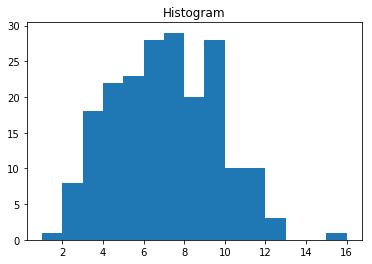

In [59]:
a = mask_list_np.sum(axis=1)

import matplotlib.pyplot as plt
plt.hist(a, bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])  # arguments are passed to np.histogram
plt.title("Histogram")
plt.show()

# Final testing

In [70]:
indices = a.argsort()
smallest_mask = mask_list[indices[10]]

In [71]:
rand_vect = mask_list[-15]
rand_vect = smallest_mask
print(rand_vect)
XE_intermediate = XE_intermediate_full[:,rand_vect]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


In [72]:
limitE = int(manager_split*len(XE_intermediate))
print(limitE)

X_train = XE_intermediate[:limitE]
X_test = XE_intermediate[limitE:]

y_train = yE[:limitE]
y_test = yE[limitE:]

452


In [73]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

logi = LogisticRegression()
logi.fit(X_train, y_train)

y_predicted = logi.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')

y_predicted_proba = logi.predict_proba(X_test)
y_predicted = (y_predicted_proba[:,1] > np.percentile(y_predicted_proba[:,1],100-percentile))

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected %.2f%% of wrong ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == False)])*100.0/(len(y_test)-sum(y_test))))
print("Accepted %.2f%% of good ones" % (len(X_test_df[(y_predicted == y_test) & (y_predicted == True)])*100.0/sum(y_test)))
print("Median: %.9f" % np.percentile(y_predicted_proba[:,1],100-percentile))

y_predicted_proba[0:5]

0.7017543859649122 0.6532634032634033 38 114
33.333333333333336 % -  16


Rejected 71.00% of wrong ones
Accepted 64.29% of good ones
Median: 0.153456826


/home/piotr.bednarski/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


array([[0.89167651, 0.10832349],
       [0.85530552, 0.14469448],
       [0.80928826, 0.19071174],
       [0.87220355, 0.12779645],
       [0.85551154, 0.14448846]])

In [64]:
contents_dict = {
    'model_svc_sklearn' : model_svc,
    'model_svc_tfidf_sklearn' : model_svc_tfidf,
    
    'model_nb_sklearn' : model_nb,
    'model_nb_tfidf_sklearn' : model_nb_tfidf,
    
    'etree_w2v_sklearn' : etree_w2v,
    'etree_w2v_tfidf_sklearn' : etree_w2v_tfidf,
    
    'svc_w2v_sklearn' : svc_w2v,
    'svc_w2v_tfidf_sklearn' : svc_w2v_tfidf,
    
    'etree_w2v_custom_sklearn' : etree_w2v_custom,
    'etree_w2v_tfidf_custom_sklearn' : etree_w2v_tfidf_custom,
    
    'svc_w2v_custom_sklearn' : svc_w2v_custom,
    'svc_w2v_tfidf_custom_sklearn' : svc_w2v_tfidf_custom,
    
    'logistic_w2v_sklearn' : logistic_w2v,
    'logistic_w2v_tfidf_sklearn' : logistic_w2v_tfidf,
    
    'sgd_w2v_sklearn' : sgd_w2v,
    'sgd_w2v_tfidf_sklearn' : sgd_w2v_tfidf,
    
    'mask_list' : mask_list,
    'ensempler' : logi
}

with open("models/"+dat_str+"ensemble_models_with_manager.pickle", 'wb') as f:
    pickle.dump(contents_dict, f, pickle.HIGHEST_PROTOCOL)